In [1]:
# cleanup
%reset -f

In [2]:
import numpy as np
import QuantLib as ql
import matplotlib.pyplot as plt

In [3]:
# Set Evaluation Date
today = ql.Date(31,3,2015)
ql.Settings.instance().setEvaluationDate(today)
calendar = ql.UnitedStates()

# handles
discCurveHdl = ql.RelinkableYieldTermStructureHandle()
fwdCurveHdl = ql.RelinkableYieldTermStructureHandle()

# ibor index
euribor6m = ql.Euribor6M(fwdCurveHdl)
eonia = ql.Eonia(discCurveHdl)

In [4]:
# ois curve
eoniaHelper = ql.DepositRateHelper(
                    ql.QuoteHandle(ql.SimpleQuote(0.015)),
                    ql.Period(1, ql.Days),
                    0, calendar,
                    ql.Following,
                    True,
                    ql.Actual360())

oisSwapHandles = list(map(lambda x: ql.QuoteHandle(x), 
                    [
                        ql.SimpleQuote(0.025),
                        ql.SimpleQuote(0.028),
                        ql.SimpleQuote(0.03),
                        ql.SimpleQuote(0.034),
                        ql.SimpleQuote(0.038),
                        ql.SimpleQuote(0.039),
                        ql.SimpleQuote(0.040),
                        ql.SimpleQuote(0.043)
                    ]))

oisSwapTerms = \
[
    ql.Period(2, ql.Weeks),
    ql.Period(1, ql.Months),
    ql.Period(6, ql.Months),
    ql.Period(1, ql.Years),
    ql.Period(5, ql.Years),
    ql.Period(10, ql.Years),
    ql.Period(15, ql.Years),
    ql.Period(20, ql.Years)
]

oisSwapHelpers = [ql.OISRateHelper(
                    2, m, q,
                    eonia)
                for q, m in zip(oisSwapHandles, oisSwapTerms)]

# Setup the discount curve
discCurve = ql.PiecewiseLogCubicDiscount(today, [eoniaHelper] + oisSwapHelpers, ql.Actual365Fixed())
discCurve.enableExtrapolation()
discCurveHdl.linkTo(discCurve)

In [5]:
# swap curve
depositHandles = list(map(lambda x: ql.QuoteHandle(x), 
                    [
                        ql.SimpleQuote(0.027),
                        ql.SimpleQuote(0.029),
                        ql.SimpleQuote(0.03),
                        ql.SimpleQuote(0.034),
                        ql.SimpleQuote(0.036), 
                        ql.SimpleQuote(0.038)
                    ]))

swapHandles = list(map(lambda x: ql.QuoteHandle(x), 
                    [
                        ql.SimpleQuote(0.045),
                        ql.SimpleQuote(0.048),
                        ql.SimpleQuote(0.05),
                        ql.SimpleQuote(0.054),
                        ql.SimpleQuote(0.058),
                        ql.SimpleQuote(0.059),
                        ql.SimpleQuote(0.060)
                    ]
                    ))

# terms
depositTerms = \
[
    ql.Period(1, ql.Days), # S/N
    ql.Period(1, ql.Weeks),
    ql.Period(1, ql.Months),
    ql.Period(2, ql.Months),
    ql.Period(3, ql.Months),
    ql.Period(6, ql.Months)
]

futureTerms = \
[
    ql.Period(1, ql.Years),
    ql.Period(2, ql.Years),
    ql.Period(3, ql.Years),
    ql.Period(5, ql.Years),
    ql.Period(10, ql.Years),
    ql.Period(15, ql.Years),
    ql.Period(20, ql.Years)
]

swapTerms = \
[
    ql.Period(1, ql.Years),
    ql.Period(2, ql.Years),
    ql.Period(3, ql.Years),
    ql.Period(5, ql.Years),
    ql.Period(10, ql.Years),
    ql.Period(15, ql.Years),
    ql.Period(20, ql.Years)
]

# helpers
depositHelpers = [ql.DepositRateHelper(q, m,
                     2,
                     calendar,
                     ql.Following,
                     True,
                     ql.Actual360())
                for q, m in zip(depositHandles, depositTerms)]

swapHelpers = [ql.SwapRateHelper(q, m,
                     calendar,
                     ql.Annual,
                     ql.Unadjusted,
                     ql.Thirty360(ql.Thirty360.European),
                     euribor6m, ql.QuoteHandle(ql.Quote()), ql.Period(0, ql.Days), discCurveHdl)
                for q, m in zip(swapHandles, swapTerms)]

# Setup the yield termstructure
fwdCurve = ql.PiecewiseLogCubicDiscount(today, depositHelpers + swapHelpers, ql.Actual365Fixed())
fwdCurve.enableExtrapolation()
fwdCurveHdl.linkTo(fwdCurve)

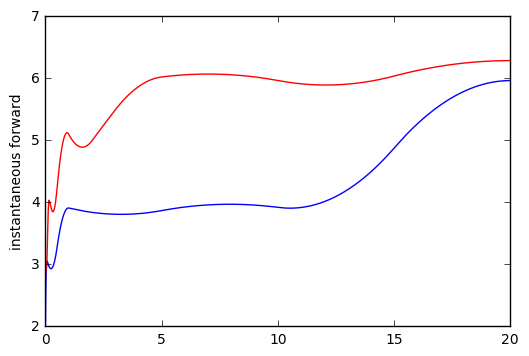

In [6]:
# plot the two curves
dates = [today]

while True:
    dates.append(dates[-1] + ql.Period(5, ql.Days))
    if dates[-1].serialNumber() >= (today + ql.Period(20, ql.Years)).serialNumber():
        break

discount = list(map(lambda x: 100 * discCurveHdl.forwardRate(x, x + ql.Period(5, ql.Days), 
                                        ql.Actual360(), ql.Simple, ql.Annual).rate(), dates))

plt.plot(list(map(lambda x: (x.serialNumber() - today.serialNumber()) / 365.0, dates)), discount, 'b')

forward = list(map(lambda x: 100 * fwdCurveHdl.forwardRate(x, x + ql.Period(5, ql.Days), 
                                        ql.Actual360(), ql.Simple, ql.Annual).rate(), dates))

plt.plot(list(map(lambda x: (x.serialNumber() - today.serialNumber()) / 365.0, dates)), forward, 'r')

plt.xlim(0., 20.0); plt.ylim(2.0, 7.0)
plt.ylabel('instantaneous forward')
plt.show()